<a href="https://colab.research.google.com/github/azamatarmanuly99/docs/blob/main/notebooks/09.00-Loop-Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [`GALigandDock` Protocol with `pyrosetta.distributed` Using the `beta_cart.wts` Scorefunction](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.02-Ligand-Docking-pyrosetta.distributed.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Using Rosetta Gen KIC](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/09.01-Using-Gen-KIC.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/09.00-Loop-Modeling.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Loop Modeling
Keywords: loops, fold_tree_from_loops, CCD, KIC, cut-point variant, FoldTree, MoveMap

Loop modeling is an important step in building homology models, designing enzymes, or docking with flexible loops. The goal of loop modeling is to predict the conformation of a short stretch of protein backbone and sidechains. Loop modeling can be used to predict structures of regions with missing density in crystal structures. Additionally, homology models often need to account for short insertions or deletions, and loop modeling can be used to predict how these sequence changes affect structure.

There are a lot of different methods for loop modeling, but the basic algorithm goes like this:

**Inputs:**

The inputs are a protein structure and a set of indices specifying where one or more regions to model (i.e. the loop or loops) start and stop. In this notebook, you'll learn how to manually set up a loop FoldTree, which will allow you to specify the regions you want to model. However, in practice, you will not need to make the FoldTree from scratch, and you will see examples of how to do this as well.

**Step 1: Initial build**

The algorithm starts by building an initial backbone for each loop being sampled. This backbone is just a starting point for the rest of the algorithm, so it's only realistic in the sense of having reasonable bond lengths and not completely clashing with anything. Note that by skipping this step, you can use the loop modeling algorithm to generate ensembles.

**Step 2: Centroid refinement**

The algorithm continues by refining the loop conformation in the context of the centroid score function. The centroid score function represents the backbone atoms in full detail, but abstracts the sidechains into spherical blobs. This creates a smoother energy landscape that is easier to explore broadly. The landscape is sampled using Monte Carlo "local backbone moves", i.e. moves that perturb the backbone within the region being sampled but not outside of it.

**Step 3: Full-atom refinement**

The algorithm finishes by refining the loop conformation in the context of the fullatom score function. This is conceptually very similar to the centroid refinement discussed above, except now all the atoms are represented in full detail and both sidechain and local backbone Monte Carlo moves are employed.

**Outputs:**

Typically, to predict a structure for a single loop, you would generate at least 500 such models and take whichever has the lowest energy. You might also calculate an RMSD for each model relative to the lowest scoring one and look for funnels in score vs. RMSD space.







## Suggested Readings

* A. Canutescu & R. L. Dunbrack, “Cyclic coordinate descent: A robotics algorithm for protein loop closure,” Protein Sci. 12, 963-972 (2003).

* Wang, P. Bradley & D. Baker, “Protein-protein docking with backbone flexibility,” J. Mol. Biol. 373, 503-519 (2007).

* J. Mandell,  E. A. Coutsias & T. Kortemme, “Sub-angstrom accuracy in protein loop reconstruction by robotics-inspired conformational sampling,” Nature Meth. 6, 551-552 (2009).

In [1]:
# Notebook setup
!pip install pyrosettacolabsetup
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
import pyrosetta; pyrosetta.init()


# py3Dmol setup (if there's an error, make sure you have 'py3Dmol' and 'ipywidgets' pip installed)
!pip install py3Dmol
import glob
import logging
logging.basicConfig(level=logging.INFO)
import os
import pyrosetta.distributed
import pyrosetta.distributed.io as io
import pyrosetta.distributed.viewer as viewer

Mounted at /content/google_drive
Looking for compatible PyRosetta wheel file at google-drive/PyRosetta/colab.bin//wheels...
Found compatible wheel: /content/google_drive/MyDrive/PyRosetta/colab.bin/wheels//content/google_drive/MyDrive/PyRosetta/colab.bin/wheels/pyrosetta-2024.1+release.00b79147e63-cp310-cp310-linux_x86_64.whl


PyRosetta-4 2023 [Rosetta PyRosetta4.MinSizeRel.python310.ubuntu 2024.01+release.00b79147e63be743438188f93a3f069ca75106d6 2023-12-25T16:35:48] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python310.ubuntu r366 2024.01+release.00b79147e63 00b79147e63be743438188f93a3f069ca75106d6 http://www.pyrosetta.org 2023-12-25T16:35:48
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.10/dist-packages/pyrosetta/database
basic.random.init_ra

In [2]:
from rosetta.core.kinematics import FoldTree
pyrosetta.init()

PyRosetta-4 2023 [Rosetta PyRosetta4.MinSizeRel.python310.ubuntu 2024.01+release.00b79147e63be743438188f93a3f069ca75106d6 2023-12-25T16:35:48] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python310.ubuntu r366 2024.01+release.00b79147e63 00b79147e63be743438188f93a3f069ca75106d6 http://www.pyrosetta.org 2023-12-25T16:35:48
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.10/dist-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-702016862 seed_offset=0 real_seed=-702016862
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-702016862 RG_type=mt19937


<ipython-input-2-d6e215a6eb3e>:1: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.core.kinematics import FoldTree


In [ ]:
# cd google_drive/MyDrive/student-notebooks

## Lever-Arm Effect

When you change the torsion angles in a given set of residues but you set the rest to not move, what will happen? Let's see the simple scheme below:

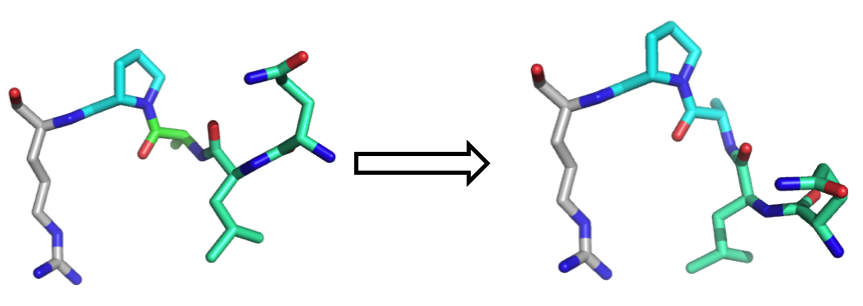

In [6]:
from IPython.display import Image
Image('small_moves.png',width='700')

You can see that in order to change one specific torsion angle in the cyan residue, all of the atoms that are to the right of that change should all move.
Below is another example where one torsion angle at the N-terminus of the protein can cause huge movements in the rest of the protein. This is called the lever arm effect.

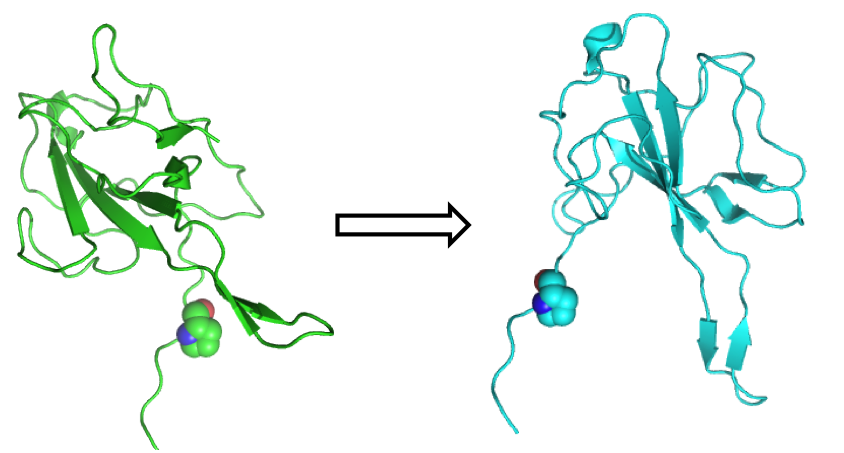

In [7]:
Image('big_moves.png',width='700')

## Fold Tree

Because we typically want to isolate the conformational changes to just our target loop region, we need a way to prevent lever-arm effects and control the movements of residues with respect to each other. This is accomplished—as was the case with protein-protein docking—with a fold tree, which is a graph that dictates the propagation of conformational changes throughout the Pose.

The fold tree stores connections in between residues as "jump edges" and "protein edges." Because Rosetta uses internal coordinates rather than Cartesian coordinates, the entire structure that you're working with has to be connected. Protein edges simply describe the connectivity of a covalently-linked peptide chain by stating the starting and ending residues. On the other hand, jump edges are the "imaginary links" that describe noncovalent connections, such as those between separate chains.

One consequence of using a fold tree is that you can tell Rosetta which residues are upstream and which are downstream. This is important because it will determine the direction in which changes propagate.

For the following exercises, you can find the working PDB, `test_in.pdb`, and a 3mer fragment file, `test_in.frag3` in the `inputs` folder.

### Fold Tree (from scratch)

Load the `test_in.pdb` structure (116 residues).
```
start_pose = pyrosetta.pose_from_file("inputs/test_in.pdb")
```

In [8]:
start_pose = pyrosetta.pose_from_file("test_in.pdb")
pose = start_pose.clone()

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 985 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 1.15908 seconds.
core.import_pose.import_pose: File 'test_in.pdb' automatically determined to be of type PDB


We want to operate on the first loop, residues 15–24. For the fold tree, we place the jump anchors two residues outside of the loop range, i.e., residues 13–26. In loop modeling, the jump points are set at i-2 and j+2, where i and j are the beginning and end residues of the loop, respectively.

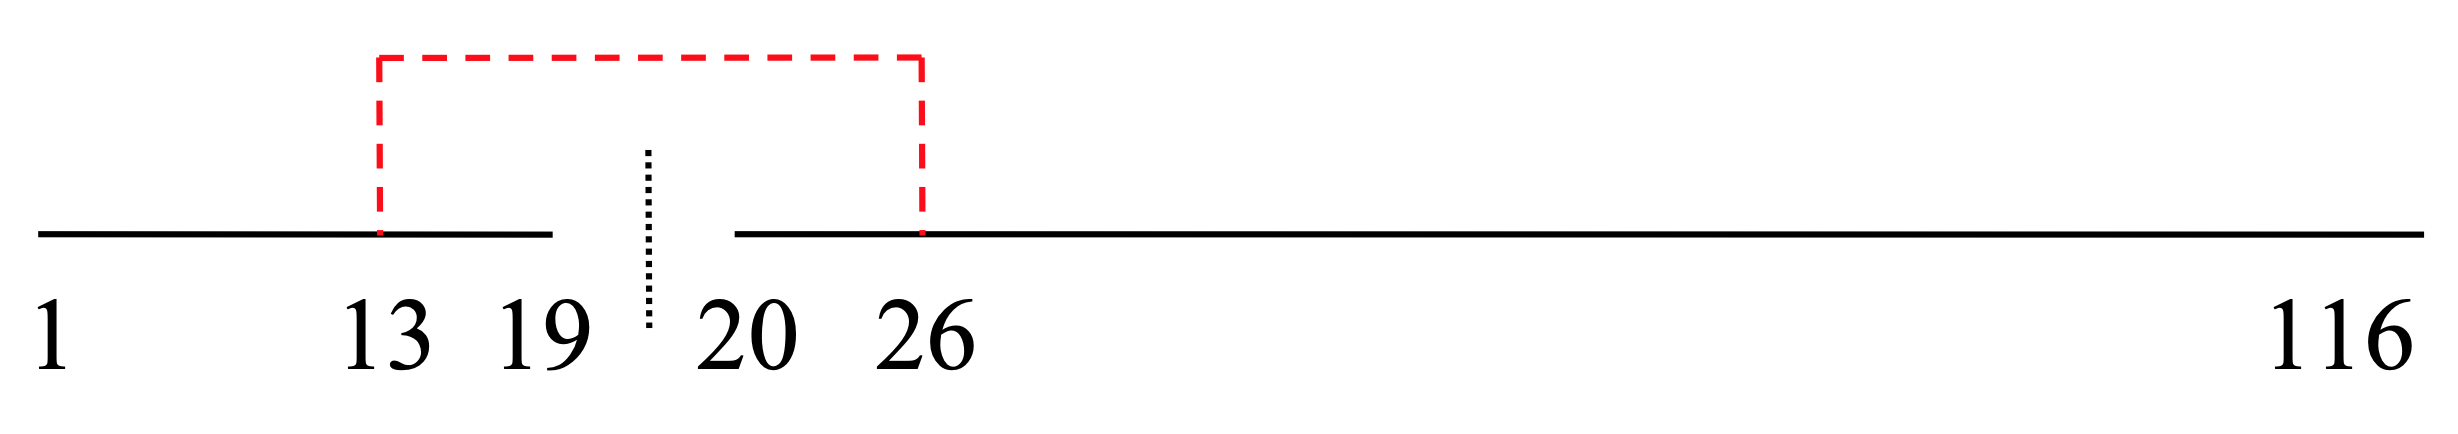

In [ ]:
Image('./Media/fold-tree1.png',width='700')

That is, we want a cut between residues 19 and 20, to allow motions in the loop that do not propagate through the rest of the protein. To tie the pieces together, we use a jump between residues 13 and 26. These residues will stay connected to each other.

To make such a tree in PyRosetta, first we create a `FoldTree` object:

```
ft = FoldTree()
```

In [9]:
ft = FoldTree()

__Be careful that you don't re-run the same cell multiple times as you will keep adding these pieces to the FoldTree, which will mess it up.__

Then we add the "edges” and the jump. Both `EDGE`s and `Jump`s are entered using the `FoldTree`’s `add_edge(start, end, code)` command, with peptide edges coded with a “-1” and jumps enumerated with the positive integers. (The first jump is coded “1”, the second “2”, etc.) The first edge is from residues 1 to 13:

```
ft.add_edge(1, 13, -1)
```

In [10]:
ft.add_edge(1, 13, -1)

(Note that this is different than saying `ft.add_edge(13, 1, -1))` because changes will propagate in the opposite direction.)

Then the second edge is from 13 to 19. __An `EDGE` must always start from a residue that has already been defined in another `EDGE`__, thus we use 13 here and not 14. (The one exception is the first edge, which starts from the graph’s “root”).

```
ft.add_edge(13, 19, -1)
```

In [11]:
ft.add_edge(13, 19, -1)

Next, the `Jump`, which is specified with the integer code 1, tells Rosetta that this is a rigid-body connection, not a peptide `EDGE`:

```
ft.add_edge(13, 26, 1)
```

In [12]:
ft.add_edge(13, 26, 1)

Finally, we add the last two `EDGE`s, both starting from 26, which is the residue that has been previously defined in the tree:

```
ft.add_edge(26, 20, -1)
ft.add_edge(26, 116, -1)
```

In [13]:
ft.add_edge(26, 20, -1)
ft.add_edge(26, 116, -1)

Print the fold tree and check that this tree is valid:

```
print(ft)
ft.check_fold_tree()
```

The latter command will return `False` if there are any invalid connections, disconnected parts, or undefined residues.

In [14]:
print(ft)
ft.check_fold_tree()

FOLD_TREE  EDGE 1 13 -1  EDGE 13 19 -1  EDGE 13 26 1  EDGE 26 20 -1  EDGE 26 116 -1 


True

Finally, we attach this fold tree to the pose, overwriting its default fold tree. Print the `Pose`'s `FoldTree` to confirm you changed it:

```
print(pose.fold_tree())
pose.fold_tree(ft)
print(pose.fold_tree())
```

In [15]:
print(pose.fold_tree())
pose.fold_tree(ft)
print(pose.fold_tree())

FOLD_TREE  EDGE 1 116 -1 
FOLD_TREE  EDGE 1 13 -1  EDGE 13 19 -1  EDGE 13 26 1  EDGE 26 20 -1  EDGE 26 116 -1 


### Fold Tree (using functions)

In the previous section, we created a FoldTree and manually created the cutpoint variants. However, it is often more practical to use the pre-made functions. In order to use these functions, we first need to make a `Loop` object.

In [16]:
from rosetta.protocols.loops import *
loop1 = Loop(15,24,19)

#### Single loop

Once you have a loop defined in a `Loop` object, you can set your fold tree with the `set_single_loop_fold_tree` command.  Note that the `FoldTree` will look slightly different compared to the one we manually created:

In [17]:
pose.assign(start_pose)
print(pose.fold_tree())

FOLD_TREE  EDGE 1 116 -1 


In [18]:
set_single_loop_fold_tree(pose, loop1)
print(pose.fold_tree())

protocols.loops.loops_main: [ WARNING ] Pose fold tree FOLD_TREE  EDGE 1 14 -1  EDGE 14 19 -1  EDGE 14 25 1  EDGE 25 20 -1  EDGE 25 116 -1
FOLD_TREE  EDGE 1 14 -1  EDGE 14 19 -1  EDGE 14 25 1  EDGE 25 20 -1  EDGE 25 116 -1 


#### Multiple Loops

Multiple loops can be stored in a `Loops` object. We can create a `loop2` object for the 78–83 loop and then create a `Loops` object:

In [19]:
loop2 = Loop(78, 83, 80)

loops = Loops()
loops.add_loop(loop1)
loops.add_loop(loop2)

Next, we can use the `fold_tree_from_loops` function, which requires a pose, a Loops object, and an empty `FoldTree`.

In [20]:
pose.assign(start_pose) # start with our original pose
ft = FoldTree() # start with an empty FoldTree

fold_tree_from_loops(pose, loops, ft);
pose.fold_tree(ft); # attaching our new FoldTree to our working pose
add_cutpoint_variants(pose);

protocols.loops.loops_main: Added cutpoint variant to residue 19
protocols.loops.loops_main: Added cutpoint variant to residue 20
protocols.loops.loops_main: Added cutpoint variant to residue 80
protocols.loops.loops_main: Added cutpoint variant to residue 81


### Exercises

1. **Optional Exercise:** Test out your fold tree. Do `pose.set_phi(res, 180)` for res values of 10, 13, 16, 23, 26 and 29. View the pose.

```
helix_selector = pyrosetta.rosetta.core.select.residue_selector.SecondaryStructureSelector("H")
loop_selector = pyrosetta.rosetta.core.select.residue_selector.SecondaryStructureSelector("L")
modules = [
    viewer.setBackgroundColor(color="black"),
    viewer.setStyle(residue_selector=helix_selector, cartoon_color="blue", label=False, radius=0),
    viewer.setStyle(residue_selector=loop_selector, cartoon_color="yellow", label=False, radius=0),
    viewer.setZoomTo(residue_selector=loop_selector)
]


pose.assign(start_pose)
for res in (10, 13, 16, 23, 26, 29):
    pose.set_phi(res, 180)
poses = [start_pose, pose]
view = viewer.init(poses, window_size=(800, 600), modules=modules).show()
```

In [21]:
helix_selector = pyrosetta.rosetta.core.select.residue_selector.SecondaryStructureSelector("H")
loop_selector = pyrosetta.rosetta.core.select.residue_selector.SecondaryStructureSelector("L")
modules = [
    viewer.setBackgroundColor(color="black"),
    viewer.setStyle(residue_selector=helix_selector, cartoon_color="blue", label=False, radius=0),
    viewer.setStyle(residue_selector=loop_selector, cartoon_color="yellow", label=False, radius=0),
    viewer.setZoomTo(residue_selector=loop_selector)
]


pose.assign(start_pose)
for res in (10, 13, 16, 23, 26, 29):
    pose.set_phi(res, 180)
poses = [start_pose, pose]
view = viewer.init(poses, window_size=(800, 600), modules=modules).show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Decoys', max=1), Output()), _do…

2. Sketch a fold tree that you could use for modeling a loop from residues 78–83. Remember that a loop from residues i to j uses a fold tree with a jump from residues i-2 to j+2.

3. What edges would you use to generate the above fold tree? See the above steps for how to add `EDGE`s to the `FoldTree`

To save some time and help avoid mistakes, there are a couple functions that will assist in the creation of fold trees:

4. Try each of the following and print the fold tree. What does each of the following do?

```
ft.clear()
print(ft)

ft.simple_tree(116)
print(ft)

ft.new_jump(76, 85, 80)
print(ft)
```

In [23]:
ft.clear()
print(ft)

ft.simple_tree(116)
print(ft)

ft.new_jump(76, 85, 80)
print(ft)

FOLD_TREE 
FOLD_TREE  EDGE 1 116 -1 
FOLD_TREE  EDGE 1 76 -1  EDGE 76 80 -1  EDGE 76 85 1  EDGE 85 116 -1  EDGE 85 81 -1 


5. Use these FoldTree methods to check your answer to question 3.

6. Use the above commands to make a fold tree to model both loops (15–24 and 78–83) simultaneously. Note you'll need more than one `Jump`

## Cyclic Coordination Descent (CCD) Loop Closure

Canutescu & Dunbrack’s CCD routine is implemented as a `Mover`. It first requires that the loop is defined using the `Loop` class. In addition to the FoldTree that you created in the previous section (whether by hand or using a function), you will also need to create a `MoveMap` with the loop residues marked as flexible (both backbone and side-chain torsion angles). Like many specialty objects in Rosetta, the CCD `Mover` is located in its own namespace and is not loaded in by default when the rest of Rosetta is imported into Python. You can either import the module or refer to its namespace when calling it. Here we show the module import:

```
from pyrosetta.rosetta.protocols.loops import Loop, Loops, set_single_loop_fold_tree, loop_rmsd
from pyrosetta.rosetta.protocols.loops.loop_closure.ccd import *
from rosetta.core.kinematics import MoveMap

loop1 = Loop(15, 24, 19)

loop_mm = MoveMap()
loop_mm.set_bb_true_range(15, 24)
loop_mm.set_chi_true_range(15, 24)

ccd = CCDLoopClosureMover(loop1, loop_mm)
print(ccd)
```

__Question:__ When declaring the `Loop` object, what do 15, 24, and 19 mean, respectively? See what is written out when you `print` the `ccd` object

In [24]:
from pyrosetta.rosetta.protocols.loops import Loop, Loops, set_single_loop_fold_tree, loop_rmsd
from pyrosetta.rosetta.protocols.loops.loop_closure.ccd import *
from rosetta.core.kinematics import MoveMap

loop1 = Loop(15, 24, 19)

loop_mm = MoveMap()
loop_mm.set_bb_true_range(15, 24)
loop_mm.set_chi_true_range(15, 24)

ccd = CCDLoopClosureMover(loop1, loop_mm)
print(ccd)

core.scoring.ramachandran: shapovalov_lib::shap_rama_smooth_level of 4( aka highest_smooth ) got activated.
basic.io.database: Database file opened: scoring/score_functions/rama/shapovalov/kappa25/all.ramaProb
Mover name: CCDLoopClosureMover, Mover type: CCDLoopClosureMover, Mover current tag:NoTag
LOOP start: 15  stop: 24  cut: 19  size: 10  skip rate: 0  extended?: False

Number of CCD cycles:    100
Tolerance:               0.08
bRama check:             True
Max total delta helix:   10
Max total delta strand:  50
Max total delta loop:    75
Movemap: 

-------------------------------
  resnum     Type  TRUE/FALSE 
-------------------------------
 DEFAULT      BB     FALSE
 DEFAULT      SC     FALSE
 DEFAULT      NU     FALSE
 DEFAULT  BRANCH     FALSE
     015      BB      TRUE
              SC      TRUE
     016      BB      TRUE
              SC      TRUE
     017      BB      TRUE
              SC      TRUE
     018      BB      TRUE
              SC      TRUE
     019      BB    

Before running the CCD algorithm, it is important to convert the residues around the cut site of the loop to “cut-point variants”:

```
add_single_cutpoint_variant(pose, loop1)
```

In [25]:
pose.assign(start_pose)
add_single_cutpoint_variant(pose, loop1)

protocols.loops.loops_main: Added cutpoint variant to residue 19
protocols.loops.loops_main: Added cutpoint variant to residue 20


7. Now that the cutpoint variant has been added, open the loop using `set_phi`, and `apply` the CCD `Mover` on the `Pose`. Does it close the loop? Is the bond across the cut point protein-like?

In [26]:
# Break the loop
pose.set_phi(16, 10) # 10 degrees is arbitrary
pose.set_phi(17, 10)
pose.set_phi(18, 10)
pose.set_phi(19, 10)
# if you want to view the pose in PyMOL on your own, here's the pdb: pose.dump_pdb("outputs/brokenloop.pdb")

view = viewer.init([start_pose, pose], window_size=(800, 600), modules=modules).show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Decoys', max=1), Output()), _do…

In [27]:
# Apply CCD Mover
ccd.apply(pose)
# if you want to view the pose in PyMOL on your own, here's the pdb:
# pose.dump_pdb("outputs/ccdloop.pdb")
view = viewer.init(pose, window_size=(800, 600), modules=modules).show()
# Compare this to brokenloop.pdb and test_in.pdb in PyMOL. What's the difference?

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

**Note:** To use CCD on multiple loops, you have to iterate over each one.

## Loop Building

The `MoveMap` and the `FoldTree` work together. By using a `MoveMap`, you can ensure that a `Mover` will only operate inside the loop region.

At this point, you should be able to write your own loop protocol that will build the loop at low-resolution using fragments. Some tips:


* Create a MoveMap that will allow motions only in the two loop regions defined in our MoveMap above.
* Create a ClassicFragmentMover using your MoveMap and the 3-residue fragment file provided, test_in.frag3.
* Use the cen_std score function, but add the chainbreak score component with a weight of 1.
* Do 100 fragment insertions.
* After each fragment insertion, close the loop with CCD, then use a MonteCarlo object to accept or reject the combination move.
* Bonus: use SequenceMover and TrialMover to tighten up your code.
* Further bonus: use the JobDistributor to allow your program to make multiple structures.

`Loop` RMSD is typically measured in a fixed reference frame of the whole protein, and it can be computed on Cα atoms or all backbone atoms. PyRosetta has a built-in function for calculating deviation of all the loops, and its output can be added as additional info in the `PyJobDistributor`. __If the `lrms` comes out to zero, return to the above cells and move one of the loops__:

```
lrms = loop_rmsd(pose, start_pose, loops, True)
print(lrms)
sfxn = get_score_function()

jd = PyJobDistributor("loop_test", 1, sfxn)
jd.additional_decoy_info = " LRMSD: " + str(lrms)
jd.output_decoy(pose)
```

(The fourth argument in `loop_rmsd()` tells whether or not the RMSD is calculated for Cα atoms only.)

In [28]:
lrms = loop_rmsd(pose, start_pose, loops, True)
print(lrms)


from pyrosetta.rosetta.core.scoring import *
sfxn = get_score_function()

12.78185289283127
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
basic.io.database: Database file opened: scoring/score_

If you first perturb the loop residues by setting all the residues to extended conformations (φ=ψ=180°), can your code close the two loops and find reasonable conformations? What is the loop RMS?

In [29]:
# prompt: If you first perturb the loop residues by setting all the residues to extended conformations (φ=ψ=180°), can your code close the two loops and find reasonable conformations? What is the loop RMS?

# Perturb the loop residues
for i in range(15, 25):
    pose.set_phi(i, 180)
    pose.set_psi(i, 180)
for i in range(78, 84):
    pose.set_phi(i, 180)
    pose.set_psi(i, 180)

# Run your loop modeling protocol
# ...

# Calculate the loop RMSD
lrms = loop_rmsd(pose, start_pose, loops, True)

# Print the loop RMSD
print("Loop RMSD:", lrms)


Loop RMSD: 21.24873479907794


If you first perturb the loop residues by setting all the residues to extended conformations (φ=ψ=180°), can your code close the two loops and find reasonable conformations? What is the loop RMS?

## High-Resolution Loop Protocol

In high-resolution, loop optimization needs smaller perturbations such as that from `Small` and `Shear` moves. The classic Rosetta loop refinement protocol is available as a `Mover` and is located in the `pyrosetta.rosetta.protocols.loops.loop_mover.refine` namespace:

```
from pyrosetta.rosetta.protocols.loops.loop_mover.refine import *
loop_refine = LoopMover_Refine_CCD(loops)
```

The `Mover` uses its own default, high-resolution score function, and it will generate its own `MoveMap` based on the definition of the loops.

In [30]:
from pyrosetta.rosetta.protocols.loops.loop_mover.refine import *
loop_refine = LoopMover_Refine_CCD(loops)

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015


`apply` this `Mover` to a few of your low-resolution loop models after switching them to full atom versions. How far does refinement move the loops? Do the loops remain closed? Note: `loop_refine.apply(pose)` might take a while.

## Kinematic Closure (KIC) Protocol

The kinematic loop closure methods of Mandell et al. are also available in several prepared `Movers` and protocols.

A single closure of a loop using the direct mathematical solution using polynomial resultants can be performed by applying the `KinematicMover`. Rather than using a `Loop` object, this `Mover` is set up by specifying the three “pivot” residues. The `KinematicMover` determines new torsion angles for the pivot residues by solving the closure equations.

```
from pyrosetta.rosetta.protocols.loops.loop_closure.kinematic_closure import *

set_single_loop_fold_tree(pose, loop1)
pmm.apply(pose)        #if viewing in PyMOL
kic_mover = KinematicMover()
kic_mover.set_pivots(16, 20, 24)
kic_mover.apply(pose)
pmm.apply(pose)        #if viewing in PyMOL
```

Like the `CCDLoopClosureMover`, the `KinematicMover` can be applied after various perturbations that alter or open the loop.

In [43]:
from pyrosetta.rosetta.protocols.loops.loop_closure.kinematic_closure import *

pose.assign(start_pose)
set_single_loop_fold_tree(pose, loop1)
pose1 = pose.clone()

kic_mover = KinematicMover()
kic_mover.set_pivots(16, 20, 24)
kic_mover.apply(pose)

poses = [pose1, pose]
view = viewer.init(poses, window_size=(800, 600), modules=modules).show()

protocols.loops.loops_main: [ WARNING ] Pose fold tree FOLD_TREE  EDGE 1 14 -1  EDGE 14 19 -1  EDGE 14 25 1  EDGE 25 20 -1  EDGE 25 116 -1
core.kinematics.AtomTree: [ WARNING ] DOF for this torsion angle could not be found in AtomTree.
core.conformation.Conformation: [ WARNING ] Unable to set torsion angle in atom_tree: TorsionID 19 BB 2
core.kinematics.AtomTree: [ WARNING ] DOF for this torsion angle could not be found in AtomTree.
core.conformation.Conformation: [ WARNING ] Unable to set torsion angle in atom_tree: TorsionID 20 BB 1
core.kinematics.AtomTree: [ WARNING ] DOF for this torsion angle could not be found in AtomTree.
core.conformation.Conformation: [ WARNING ] Unable to set torsion angle in atom_tree: TorsionID 19 BB 2
core.kinematics.AtomTree: [ WARNING ] DOF for this torsion angle could not be found in AtomTree.
core.conformation.Conformation: [ WARNING ] Unable to set torsion angle in atom_tree: TorsionID 20 BB 1
core.kinematics.AtomTree: [ WARNING ] DOF for this torsio

interactive(children=(IntSlider(value=0, continuous_update=False, description='Decoys', max=1), Output()), _do…

The full loop prediction protocol of Mandell et al. has been implemented as separate `Movers` for the low- and high-resolution stages. The `LoopMover_Perturb_KIC` operates on a centroid representation `Pose`, and it is designed to predict a loop de novo. The `LoopMover_Refine_KIC` operates in the full-atom representation, and it is designed to refine a loop making small perturbations from a starting conformation such as one output by the `LoopMover_Perturb_KIC` `Mover`. Here is an example of the usage of both:
```
from pyrosetta.rosetta.protocols.loops.loop_mover.perturb import *
from pyrosetta.rosetta.protocols.loops.loop_mover.refine import *

loops = Loops()
loops.add_loop(loop1)

set_single_loop_fold_tree(pose, loop1)

sw = SwitchResidueTypeSetMover("centroid")
sw.apply(pose)
kic_perturb = LoopMover_Perturb_KIC(loops)
#kic_perturb.apply(pose)
sw = SwitchResidueTypeSetMover("fa_standard")
sw.apply(pose)
kic_refine = LoopMover_Refine_KIC(loops)
#kic_refine.apply(pose)
```

__Because these are full prediction protocols, they will require some time to perform on your computer.__ Each will result in a single decoy structure; note that Mandell et al. generated 1000 decoy structures for blind predictions of 12-residue loops.

11. Time permitting, repeat exercises 8–10, replacing the CCD `Mover` with the appropriate kinematic `Movers`.

## Simultaneous Loop Modeling and Docking

Antibodies have two chains, light (L) and heavy (H), which can move relative to each other. They also have a long, hypervariable H3 loop, typically residues 95–102. Antibodies are common protein drugs, and they are often created by exploiting the immune system of a mouse. There is a need for high-quality homology models of antibodies.

12. Sketch a fold tree that you could use to model an antibody with a flexible H3 loop and H and L chains that can move relative to each other.

In [ ]:
# prompt: Sketch a fold tree that you could use to model an antibody with a flexible H3 loop and H and L chains that can move relative to each other.

Image('./Media/fold-tree2.png',width='700')


13. Write a low-resolution protocol to alternate docking and loop modeling steps. Use your code to model cetuximab. Use the job distributor to track your decoys. What is the lowest RMSD you can create in 100 decoys?

**Chapter contributors:**

- Jared Adolf-Bryfogle (Scripps; Institute for Protein Innovation)
- Kathy Le (Johns Hopkins University); parts of this chapter were adapted from the PyRosetta book (J. J. Gray, S. Chaudhury, S. Lyskov, J. Labonte) and the [Rosetta Commons docs page](https://www.rosettacommons.org/docs/latest/Home)

<!--NAVIGATION-->
< [`GALigandDock` Protocol with `pyrosetta.distributed` Using the `beta_cart.wts` Scorefunction](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.02-Ligand-Docking-pyrosetta.distributed.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Using Rosetta Gen KIC](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/09.01-Using-Gen-KIC.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/09.00-Loop-Modeling.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>